In [1]:
import numpy as np                  # Mathetimatical Operations
import pandas as pd                 # Data manipulation

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt     
import matplotlib.dates as md
%matplotlib inline

# Sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, classification_report, mean_squared_error, confusion_matrix, f1_score, precision_recall_curve, r2_score 
from sklearn.ensemble import IsolationForest, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

# Scipy
from scipy.stats import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

# XGBoost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import xgboost as xgb

# LightGBM
import lightgbm as lgb

# Datetime
import datetime 
import time
from datetime import datetime

# Folium
import folium 
from folium import plugins
from folium.plugins import HeatMap

# Image
from IPython.display import Image

# Bayesian Optimizer
from skopt import BayesSearchCV

# Itertools
import itertools

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


#### Motivation :

I read an interesting article about anomaly detection: https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/.
I wanted to try a few of these techniques to better understand them. I searched an interesting dataset on Kaggle about anomaly detection with simple exemples. I choose one exemple of NAB datasets (thanks for this datasets) and I implemented a few of these algorithms. The goal of this Notebook is just to implement these techniques and understand there main caracteristics. Sometimes, they are not adapted to this datasets. I add some visualizations to understand what the algorithm detect. Hope it can help some people. Notebook available (with Markov Chain) here: https://github.com/Vicam/Unsupervised_Anomaly_Detection

#### Interesting Article on Anomaly Detection

https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/

#### Algorithm implemented :

- Cluster based anomaly detection (K-mean)
- Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately
- Markov Chain
- Isolation Forest
- One class SVM
- RNN (comparison between prediction and reality)

In [2]:
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

#### 1.1 Extract data

The dataset is from https://www.kaggle.com/boltzmannbrain/nab In realKnownCause/ambient_temperature_system_failure.csv

In [62]:
df = pd.read_csv('machine_temperature_system_failure.csv') 

#### 1.2 Data Exploration

In [63]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
timestamp    22695 non-null object
value        22695 non-null float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


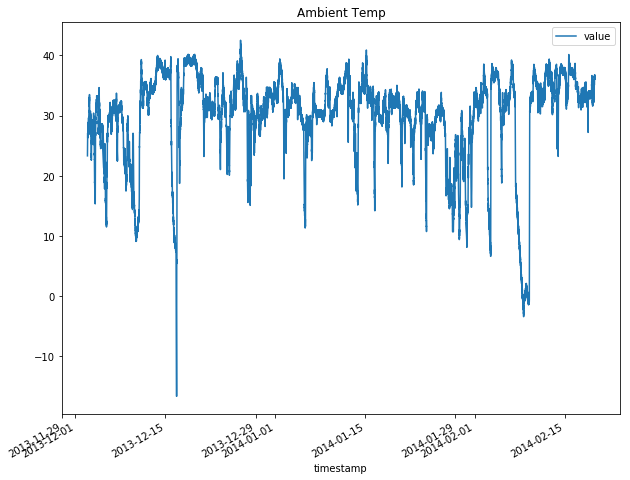

In [65]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value',title='Ambient Temp', figsize=(10,8))

#### 1.3 Feature Engineering 

In [66]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [67]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [71]:
df.head()

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay
0,2013-12-02 21:15:00,23.315179,21,1,0,1
1,2013-12-02 21:20:00,23.853268,21,1,0,1
2,2013-12-02 21:25:00,24.513423,21,1,0,1
3,2013-12-02 21:30:00,25.633726,21,1,0,1
4,2013-12-02 21:35:00,26.294353,21,1,0,1


In [72]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

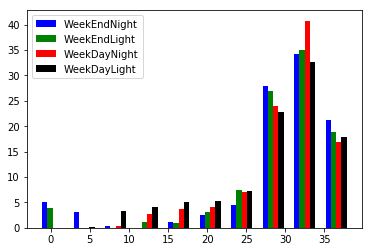

In [73]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

We can see that the temperature is more stable during daylight of business day.

### 2. Models

#### 2.1 Cluster based

Use for collective anomalies (unordered).
We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [74]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

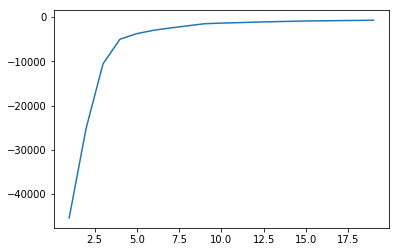

In [75]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [76]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

3     1848
2     1848
9     1556
8     1535
0     1521
7     1499
14    1486
11    1482
13    1468
10    1463
4     1447
5     1417
12    1401
6     1366
1     1358
Name: cluster, dtype: int64

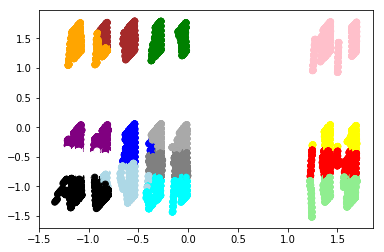

In [77]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan'
          , 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [78]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)


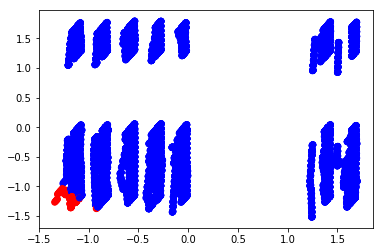

In [79]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()


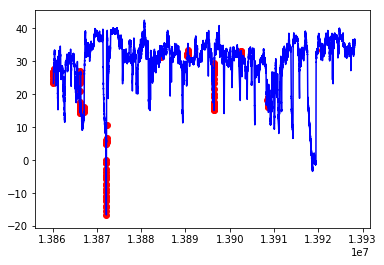

In [80]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

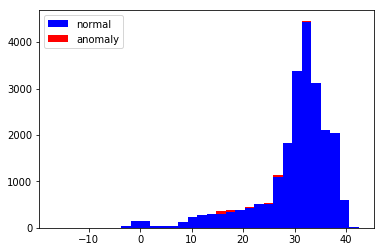

In [81]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Cluster method detects the low temperature around the end of record as unusually low. It doesn't detect the highest temperature pic.

#### 2.2 Categories + Gaussian

Use for contextual data and collective anomalies (unordered).
We will separate data by (what we think of) important categories. Or we can separate data based on different cluster (method 2.3). Then we find outliers (gaussian repartition, unimodal) by categories independently.

In [82]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']


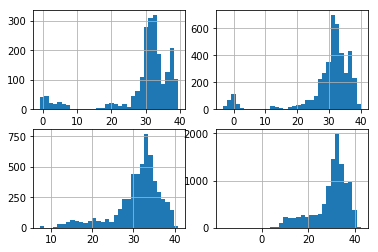

In [83]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)


In [84]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

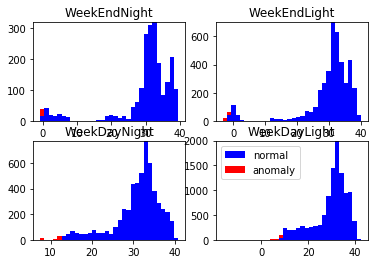

In [85]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [86]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

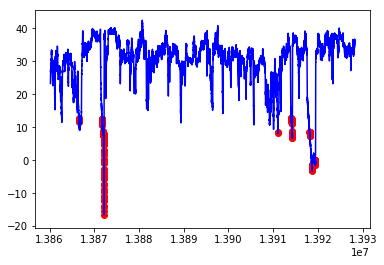

In [87]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

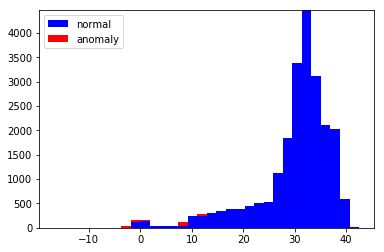

In [88]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()


Good detections of extreme values and context separation add some precision to the detection.

#### 2.3 Cluster+Gaussian

Similar to 2.2 solution but with cluster to separate data in different group.

#### 2.4 Markov chains

Use for sequential anomalies (ordered)
We need discretize the data points in define states for markov chain. We will just take 'value' to define state for this example and define 5 levels of value (very low, low, average, high, very high)/(VL, L, A, H, VH). Markov chain will calculate the probability of sequence like (VL, L, L, A, A, L, A). If the probability is very weak we consider the sequence as an anomaly.

In [89]:
# # definition of the different state
# x1 = (df['value'] <=18).astype(int)
# x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
# x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
# x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
# x5 = (df['value'] >27).astype(int)
# df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

# # getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
# # I USE pyemma NOT AVAILABLE IN KAGGLE KERNEL
# df_anomaly = markovAnomaly(df_mm, 5, 0.20)
# df_anomaly = pd.Series(df_anomaly)
# print(df_anomaly.value_counts())


In [90]:

# # add the data to the main 
# df['anomaly24'] = df_anomaly

# # visualisation of anomaly throughout time (viz 1)
# fig, ax = plt.subplots()

# a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

# ax.plot(df['time_epoch'], df['value'], color='blue')
# ax.scatter(a['time_epoch'],a['value'], color='red')
# plt.show()

In [91]:
# # visualisation of anomaly with temperature repartition (viz 2)
# a = df.loc[df['anomaly24'] == 0, 'value']
# b = df.loc[df['anomaly24'] == 1, 'value']

# fig, axs = plt.subplots()
# axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
# plt.legend()
# plt.show()

Detect unusual sequence but not extreme value. More difficult to evaluate the relevance on this example. The sequence size (5) should be match with some interesting cycle.

#### 2.5 Isolation Forest

Use for collective anomalies (unordered).
Simple, works well with different data repartition and efficient with high dimention data.

In [92]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    22471
1      224
Name: anomaly25, dtype: int64


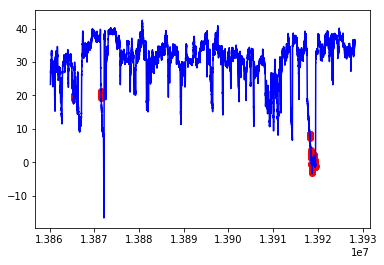

In [93]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

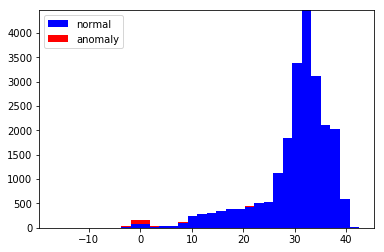

In [94]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()


#### 2.6 One class SVM

Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [95]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())
2.6 One class SVM
Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

0    22476
1      219
Name: anomaly26, dtype: int64


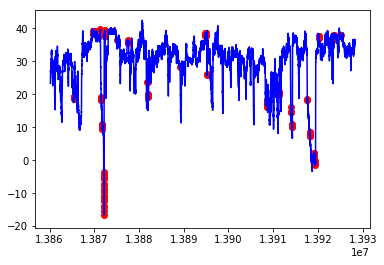

In [96]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

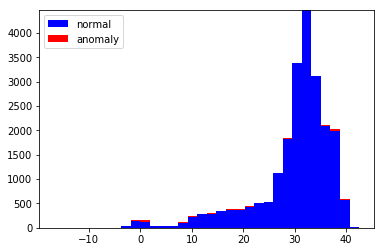

In [97]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()


Give result similar to isolation forest but find some anomalies in average values. Difficult to know if it's relevant.

#### 2.7 RNN

Use for sequential anomalies (ordered)
RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [48]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

In [49]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [50]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

Using TensorFlow backend.


In [51]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.02101612091064453


In [90]:
# Train the model
#nb_epoch = 350

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=30,
    validation_split=0.1)

Train on 5548 samples, validate on 617 samples
Epoch 1/30
5548/5548 [==============================] - 7s 1ms/step - loss: 0.6755 - val_loss: 0.6371
Epoch 2/30
5548/5548 [==============================] - 5s 931us/step - loss: 0.1940 - val_loss: 0.4178
Epoch 3/30
5548/5548 [==============================] - 5s 899us/step - loss: 0.1519 - val_loss: 0.2619
Epoch 4/30
5548/5548 [==============================] - 4s 727us/step - loss: 0.1068 - val_loss: 0.2422
Epoch 5/30
5548/5548 [==============================] - 4s 782us/step - loss: 0.1022 - val_loss: 0.2171
Epoch 6/30
5548/5548 [==============================] - 4s 674us/step - loss: 0.0931 - val_loss: 0.1893
Epoch 7/30
5548/5548 [==============================] - 4s 767us/step - loss: 0.1004 - val_loss: 0.1681
Epoch 8/30
5548/5548 [==============================] - 4s 710us/step - loss: 0.1003 - val_loss: 0.1579
Epoch 9/30
5548/5548 [==============================] - 4s 786us/step - loss: 0.0839 - val_loss: 0.1484
Epoch 10/30
5548/55

In [91]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))


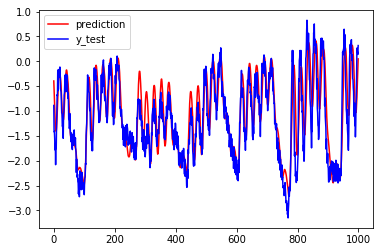

In [92]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [93]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


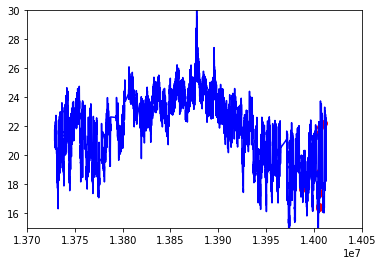

In [94]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()


No handles with labels found to put in legend.


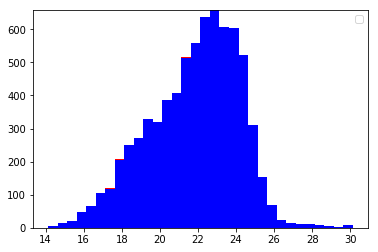

In [95]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

#### 2.8 Collective and sequential anomalies (Ordered)
This class is most general and consider ordering as well as value combinations. We usually use combination of algorithm like cluster+markov model.

#### 3 Result comparison
(may be later)

#### 4 Conclusion
For this case, the contextual anomaly detection (categories+elliptique enveloppe) seem a good solution.